In [1]:
from os.path import expanduser, join, abspath
import datetime as dt
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np
np.random.seed(2019)
from pprint import pprint
import string
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.4f')

from operator import itemgetter

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.functions import unix_timestamp

from os.path import expanduser, join, abspath
import datetime as dt
import sys
import time

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *




In [2]:
df_reviews = pd.read_csv('/home/ag27675/Disc2_QC/Data/Amazon_Reviews.csv').head(60000)
df_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning

In [3]:
start = time.time()
#Convert to a list of all lowercase texts
comments_orign = df_reviews['Text'].map(lambda x: x.lower()).values.tolist()

#Replace null with None 
comments = [re.sub(r"null|n/a.", "None", i) for i in comments_orign]

#Remove new line characters
comments = [re.sub('\s+', ' ', i) for i in comments]

# #Remove distracting single quotes
# comments = [re.sub("\'", "", i) for i in comments]

#Remove html line break 
comments = [re.sub("<br />|<br />|</a>|<a href=", " ", i) for i in comments]

#Remove punctuation
comments = [re.sub('[,\.;!?>]', ' ', i) for i in comments]

#Normalize spaces to 1
comments = [re.sub(" +", " ", i) for i in comments]
print('Total time: ' + str((time.time() - start)/60) + ' mins')

Total time: 0.15503644943237305 mins


In [4]:
comments[21]

'i bought these for my husband who is currently overseas he loves these and apparently his staff likes them also there are generous amounts of twizzlers in each 16-ounce bag and this was well worth the price "http://www amazon com/gp/product/b001gvisjm" twizzlers strawberry 16-ounce bags (pack of 6) '

# Exploratory Data Analysis

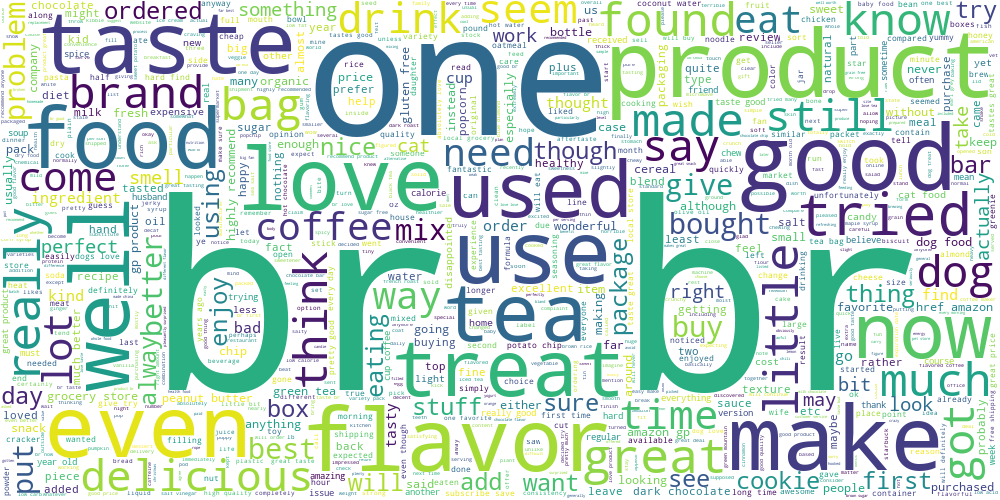

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(comments_orign)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                        width=1000, height=500,
                        max_words=5000, contour_width=20, 
                        contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# # Display the generated image:
# # the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# # lower max_font_size
# wordcloud = wordcloud.generate(long_string)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [6]:
df_reviews['Text'][21]

'I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. <a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [7]:
comments[21]

'i bought these for my husband who is currently overseas he loves these and apparently his staff likes them also there are generous amounts of twizzlers in each 16-ounce bag and this was well worth the price "http://www amazon com/gp/product/b001gvisjm" twizzlers strawberry 16-ounce bags (pack of 6) '

# Preprocess Data: Decompose Sentences

In [8]:
start = time.time()
def sent_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True)) #deacc = True removes punctuations 
        
cleaned_comments = list(sent_to_words(comments))
print('Total time: ' + str((time.time() - start)/60) + ' mins')

Total time: 0.48302441040674843 mins


In [9]:
cleaned_comments[21]

['bought',
 'these',
 'for',
 'my',
 'husband',
 'who',
 'is',
 'currently',
 'overseas',
 'he',
 'loves',
 'these',
 'and',
 'apparently',
 'his',
 'staff',
 'likes',
 'them',
 'also',
 'there',
 'are',
 'generous',
 'amounts',
 'of',
 'twizzlers',
 'in',
 'each',
 'ounce',
 'bag',
 'and',
 'this',
 'was',
 'well',
 'worth',
 'the',
 'price',
 'http',
 'www',
 'amazon',
 'com',
 'gp',
 'product',
 'gvisjm',
 'twizzlers',
 'strawberry',
 'ounce',
 'bags',
 'pack',
 'of']

# Remove stopwords, make bigrams and Lemmatize

In [9]:
from nltk.corpus import stopwords

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.append("one")

[nltk_data] Downloading package stopwords to
[nltk_data]     /local_home/ag27675/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Remove Stop words
def remove_stopwords(texts):
    return [[i for i in simple_preprocess(str(doc)) if i not in stop_words] for doc in texts]

start = time.time()
cleaned_comments_nonstops = remove_stopwords(cleaned_comments)
print('Total time: ' + str((time.time() - start)/60) + ' mins')

Total time: 0.5865000486373901 mins


In [11]:
#Form Bigram 
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

start = time.time()
bigram = gensim.models.Phrases(cleaned_comments, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[cleaned_comments], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)
print('Total time: ' + str((time.time() - start)/60) + ' mins')

start = time.time()
cleaned_comments_bigrams = make_bigrams(cleaned_comments_nonstops)
print('Total time: ' + str((time.time() - start)/60) + ' mins')

Total time: 0.6374560674031575 mins
Total time: 0.27438884576161704 mins


# NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word.

In [12]:
nltk.download('wordnet')

from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

from nltk.stem import WordNetLemmatizer
def lemmatize(texts):
    text_out = []
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        lemmatized_output = [lemmatizer.lemmatize(get_lemma(w)) for w in text]
        text_out.append(lemmatized_output)
    return text_out

#Lemmatization
start = time.time()
final_data = lemmatize(cleaned_comments_bigrams)
print('Total time: ' + str((time.time() - start)/60) + ' mins')

[nltk_data] Downloading package wordnet to
[nltk_data]     /local_home/ag27675/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Total time: 1.055152996381124 mins


# Create Dictionary and Corpus needed for topic modeling

In [15]:
from gensim import corpora

start = time.time()
#Create Dictionary 
id2word = corpora.Dictionary(final_data)

# Create Corpus
texts = final_data

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]
print('Total time: ' + str((time.time() - start)/60) + ' mins')

Total time: 0.21594479481379192 mins


In [16]:
id2word[84]

'assortment'

In [ ]:
comments[4]

In [ ]:
final_data[4]

In [22]:
corpus[90:92]

[[(6, 2),
  (89, 1),
  (148, 1),
  (163, 1),
  (211, 1),
  (227, 1),
  (269, 1),
  (455, 1),
  (531, 1),
  (754, 1),
  (1062, 1),
  (1112, 1),
  (1113, 1),
  (1114, 1),
  (1115, 1),
  (1116, 1)],
 [(4, 2), (6, 1), (87, 1), (96, 1), (1082, 1), (1117, 1), (1118, 1)]]

# Find optimal number of topics for LDA

In [19]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

def compute_coherence_values(dictionary, corpus, texts, max_topics, start, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, max_topics, step):
        lda_model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, 
                         workers=30, eval_every = 1,chunksize = 1000, 
                         passes =1, alpha = 'symmetric', per_word_topics = True)
#         lda_model = LdaModel(corpus = corpus, id2word = id2word,
#                              num_topics =num_topics, update_every = 1,
#                              chunksize = 1000, passes =10,
#                              alpha = 'auto', per_word_topics = True)
        print(num_topics)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model = lda_model, 
                                        texts= texts, 
                                        dictionary = dictionary,
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [20]:
start = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus = corpus,
                                                        texts = final_data,
                                                        start=2,
                                                        max_topics=11,
                                                        step=1)
print('Total time: ' + str((time.time() - start)/60) + ' mins')

2
3
4
5
6
7
8
9
10
Total time: 3.5566828807195026 mins


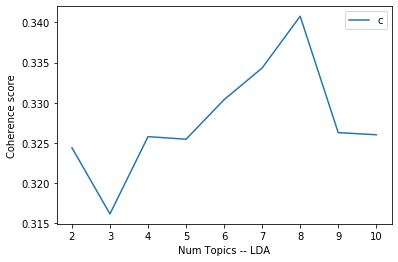

In [21]:
#Show graph
import matplotlib.pyplot as plt
%matplotlib inline

limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics -- LDA")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores¶

In [37]:
num_lst = []
cv_lst = []
for m, cv in zip(x, coherence_values):
    num_lst.append(m)
    cv_lst.append(cv)
    print("Number of Topics =", m, "has Coherence Value of ", round(cv,4))


Number of Topics = 2 has Coherence Value of  0.3244
Number of Topics = 3 has Coherence Value of  0.3162
Number of Topics = 4 has Coherence Value of  0.3258
Number of Topics = 5 has Coherence Value of  0.3255
Number of Topics = 6 has Coherence Value of  0.3304
Number of Topics = 7 has Coherence Value of  0.3343
Number of Topics = 8 has Coherence Value of  0.3408
Number of Topics = 9 has Coherence Value of  0.3263
Number of Topics = 10 has Coherence Value of  0.326


In [38]:
optimal_indx = cv_lst.index(max(cv_lst))
round(cv_lst[optimal_indx],4)

0.3408

In [39]:
optimal_indx

6

In [40]:
#Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics())

[(0,
  '0.028*"coffee" + 0.014*"great" + 0.011*"taste" + 0.011*"product" + '
  '0.009*"good" + 0.009*"like" + 0.009*"love" + 0.008*"make" + 0.008*"cup" + '
  '0.007*"flavor"'),
 (1,
  '0.020*"taste" + 0.015*"like" + 0.013*"good" + 0.011*"try" + 0.009*"love" + '
  '0.009*"product" + 0.008*"tea" + 0.008*"make" + 0.007*"get" + '
  '0.007*"coffee"'),
 (2,
  '0.015*"flavor" + 0.014*"like" + 0.011*"get" + 0.011*"chip" + 0.009*"food" + '
  '0.009*"dog" + 0.009*"taste" + 0.008*"buy" + 0.008*"bag" + 0.008*"would"'),
 (3,
  '0.017*"tea" + 0.014*"taste" + 0.011*"like" + 0.010*"flavor" + '
  '0.010*"product" + 0.008*"love" + 0.008*"make" + 0.007*"get" + 0.007*"use" + '
  '0.007*"food"'),
 (4,
  '0.019*"food" + 0.017*"like" + 0.014*"dog" + 0.010*"good" + 0.009*"make" + '
  '0.008*"product" + 0.008*"flavor" + 0.007*"amazon" + 0.007*"get" + '
  '0.007*"love"'),
 (5,
  '0.017*"like" + 0.017*"good" + 0.010*"product" + 0.009*"taste" + '
  '0.008*"would" + 0.008*"make" + 0.008*"love" + 0.008*"price" + 0.

In [44]:
import pyLDAvis
pyLDAvis.enable_notebook()

from pyLDAvis import gensim

start = time.time()
# vis=gensim.prepare(optimal_model, corpus, id2word)
lda_display = gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
print('Total time: ' + str((time.time() - start)/60) + ' mins')
pyLDAvis.save_html(lda_display, 'amazon_reviews_lda8.html')


Total time: 2.7987650950749714 mins


In [45]:
pyLDAvis.display(lda_display)


In [47]:
lda_model=optimal_model
lda_topics = lda_model[corpus][0:len(corpus)]

dominant_topic_lst=[]
topic_prob_lst = []
keywords_lst = []

start = time.time()
for i, (a1,b1,c1) in enumerate(lda_topics):
    dominant_topic_lst.append(sorted(a1, key=itemgetter(1), reverse=True)[0][0])
    topic_prob_lst.append(str(round(sorted(a1, key=itemgetter(1), reverse=True)[0][1],4)))

    wp = lda_model.show_topic(sorted(a1, key=itemgetter(1), reverse=True)[0][0])
    topic_keywords = ", ".join([word for word, prop in wp])
    keywords_lst.append(topic_keywords)
    if i!=0 and i%10000==0:
        print(i)
        with open('domaint_topic_lst5.txt', 'w') as filehandle1:
            json.dump(dominant_topic_lst, filehandle1)
        with open('topic_prob_lst5.txt', 'w') as filehandle1:
            json.dump(topic_prob_lst, filehandle1)
        with open('keywords_lst5.txt', 'w') as filehandle1:
            json.dump(keywords_lst, filehandle1)
print('Total time to get dominant_topic: ' + str((time.time() - start)/60) + ' mins')


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
Total time to get dominant_topic: 4.779248058795929 mins


In [48]:
df_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [53]:
topics_df = pd.DataFrame()
topics_df.reset_index()

topics_df['ID'] = df_reviews.Id.values.tolist()
topics_df['Profile_Name'] = df_reviews.ProfileName.values.tolist()
topics_df['Summary'] = df_reviews.Summary.values.tolist()
topics_df['Raw Review'] = df_reviews.Text.values.tolist()
topics_df['Dominant Topic'] =dominant_topic_lst
topics_df['Topic Percent Contribution'] = topic_prob_lst
topics_df['Keywords extracted from model'] = keywords_lst
topics_df.head(5)

,ID,Profile_Name,Summary,Raw Review,Dominant Topic,Topic Percent Contribution,Keywords extracted from model
0,1,delmartian,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,0.5392,"like, good, product, taste, would, make, love,..."
1,2,dll pa,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,6,0.6753,"use, product, try, get, coffee, taste, flavor,..."
2,3,"Natalia Corres ""Natalia Corres""","""Delight"" says it all",This is a confection that has been around a fe...,0,0.9774,"coffee, great, taste, product, good, like, lov..."
3,4,Karl,Cough Medicine,If you are looking for the secret ingredient i...,3,0.7823,"tea, taste, like, flavor, product, love, make,..."
4,5,"Michael D. Bigham ""M. Wassir""",Great taffy,Great taffy at a great price. There was a wid...,7,0.6492,"flavor, great, like, love, cup, dog, get, coff..."


In [54]:
topics_df.to_json(r'/home/ag27675/Disc2_QC/Data/amazon_reviews_topics.json')

In [23]:
import pandas as pd
topics_df = pd.read_json(r'/home/ag27675/Disc2_QC/Data/amazon_reviews_topics.json')
samples=topics_df.drop(columns=['Profile_Name', 'ID']).sample(10).reset_index()
samples.drop(columns=['index'])

,Summary,Raw Review,Dominant Topic,Topic Percent Contribution,Keywords extracted from model
0,I love this one!,The aroma of this tea is heavenly. Very fruit...,3,0.9415,"tea, taste, like, flavor, product, love, make,..."
1,Great flavor and SO FRESH,I find many snack foods too salty for my taste...,5,0.9471,"like, good, product, taste, would, make, love,..."
2,great beans - for a friend,I ordered a case of these kidney beans by mist...,6,0.9769,"use, product, try, get, coffee, taste, flavor,..."
3,Great Flavor,Whole family loved 'em. Hard enough to break y...,2,0.9416,"flavor, like, get, chip, food, dog, taste, buy..."
4,My favorite Starbucks blend!,"I have tried all the Via blends, and my favori...",0,0.9863,"coffee, great, taste, product, good, like, lov..."
5,DELICIOUS and NUTRITIOUS :),This is a delicious whole grain product--what ...,7,0.9325,"flavor, great, like, love, cup, dog, get, coff..."
6,BEST GLUTEN FREE BREAD BRAND,BOTTOM LINE<br />Schar makes the best gluten f...,4,0.5923,"food, like, dog, good, make, product, flavor, ..."
7,More bang for my buck!Q,"Since we've had a keurig, we've gone through m...",7,0.9090,"flavor, great, like, love, cup, dog, get, coff..."
8,Good Almonds,"I like a good nut, and these Emerald Cocoa Roa...",5,0.4423,"like, good, product, taste, would, make, love,..."
9,So yummy!,"Oh my GOODNESS, this was DELICIOUS. This snac...",2,0.5937,"flavor, like, get, chip, food, dog, taste, buy..."


In [26]:
samples['Raw Review'][7]

"Since we've had a keurig, we've gone through many varieties of kcup coffees including flavored and non flavored. Every kcup seemed to be either weak, bitter, acidic, or just ordinary. We have found OUR FAVORITE with this one. It's strong, flavorful, and smooth. Comes exactly as described by the seller, order promptly processed, arrives quickly. Can't beat it in our opinion. I can recommend this coffee and the seller with confidence."

In [27]:
samples['Keywords extracted from model'][7]

'flavor, great, like, love, cup, dog, get, coffee, try, use'